# Fine‑tuning DeBERTa‑v3‑base Cross‑Encoder for Hallucination Detection
This notebook shows how to fine‑tune a **cross‑encoder** built on `microsoft/deberta‑v3‑base` to classify hallucination labels (`PASS` = grounded, `FAIL` = hallucinated) on the **HaluEval** dataset and on a domain-specific (retail bank customer service) synthetic dataset.  

**Main steps**
1. Install / import libraries  
2. Load & preprocess the dataset (`query`, `response`, `label`)  
3. Tokenise text pairs with DeBERTa tokenizer  
4. Fine‑tune using `Trainer` API (PyTorch backend)  
5. Evaluate & save the model for later inference



In [1]:
import pandas as pd
import torch, random, numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

SEED = 42
set_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [2]:
import transformers
print(transformers.__version__)


4.52.4


## 1  Load HaluEval and domain-specific dataset

In [3]:
# === Configuration ===
#input_path = "../data/halueval_groundedness.csv"
#output_path = "../data/halueval_biencoder_results.csv"

#input_path_challenger = "../data/synthetic_groundedness_challenger_set_long.csv"
#output_path_challenger = "../data/synthetic_groundedness_challenger_set_biencoder_results.csv"


# === Configuration for Google Colab ===
input_path = "/content/halueval_groundedness.csv"
output_path = "/content/halueval_biencoder_results.csv"

input_path_challenger = "/content/synthetic_groundedness_challenger_set_long.csv"
output_path_challenger = "/content/synthetic_groundedness_challenger_set_biencoder_results.csv"

from google.colab import files
#Upload files
uploaded = files.upload()

Saving halueval_groundedness.csv to halueval_groundedness.csv
Saving synthetic_groundedness_challenger_set_long.csv to synthetic_groundedness_challenger_set_long.csv


In [4]:
# Load datasets
gen_df = pd.read_csv(input_path)
dom_df = pd.read_csv(input_path_challenger)

print("HaluEval:", gen_df.shape)
print("Challenger:", dom_df.shape)
display(gen_df.head())
display(dom_df.head())

HaluEval: (1000, 4)
Challenger: (770, 4)


,query,context,response,label
0,The manager in which Mark Lazarus clashed with...,He transferred to Wolverhampton Wanderers for...,1948 and 1964,PASS
1,The manager in which Mark Lazarus clashed with...,He transferred to Wolverhampton Wanderers for...,Mark Lazarus clashed with the manager of Wolve...,FAIL
2,"No. 11 Squadron RAAF was based at what base, 2...",No. 11 Squadron is a Royal Australian Air Forc...,RAAF Base Edinburgh,PASS
3,"No. 11 Squadron RAAF was based at what base, 2...",No. 11 Squadron is a Royal Australian Air Forc...,"RAAF Base Edinburgh, located in Australia.",FAIL
4,Which movie starring Kim Roi-ha is based on Ko...,"Kim Roi-ha (born November 15, 1965) is a South...",Memories of Murder,PASS


,query,context,response,label
0,I made a big purchase that I regretted and can...,### Refund Not Showing Up? Here's What You Nee...,"To verify your refund, please follow these ste...",PASS
1,I am still waiting to find out the status of m...,**Refund Status Inquiry**\r\n\r\nWe understand...,We understand that waiting for a refund can be...,PASS
2,"As advised by you, i requested seller to refun...",### Refund Status Inquiry\r\n\r\nThank you for...,Thank you for reaching out to us regarding you...,PASS
3,"Hurry and refund me, I am waiting",### Refund Not Showing Up\r\n\r\nWe understand...,We understand that waiting for a refund can be...,PASS
4,I was supposed to get a refund but I do not se...,**FAQ: My Refund is Not Showing Up**\r\n\r\nIf...,If you are expecting a refund but do not see i...,PASS


In [5]:
# Map labels from strings into numeric
label_map = {'PASS': 1, 'FAIL': 0}
gen_df['label'] = gen_df['label'].map(label_map)
dom_df['label'] = dom_df['label'].map(label_map)

# Combine query and context with markers
gen_df['query_context'] = "Query: " + gen_df['query'].astype(str) + " Context: " + gen_df['context'].astype(str)
dom_df['query_context'] = "Query: " + dom_df['query'].astype(str) + " Context: " + dom_df['context'].astype(str)

# Check label mapping
assert gen_df['label'].isna().sum() == 0, 'Unknown labels in gen_df!'
assert dom_df['label'].isna().sum() == 0, 'Unknown labels in dom_df!'

print("General label counts:\n", gen_df['label'].value_counts())
print("Challenger label counts:\n", dom_df['label'].value_counts())


General label counts:
 label
1    500
0    500
Name: count, dtype: int64
Challenger label counts:
 label
1    385
0    385
Name: count, dtype: int64


In [6]:
VAL_FRAC = 0.15
TEST_FRAC = 0.15
SEED = 42

def group_pairs(df):
    pair_key = ['query', 'context']
    groups = df.groupby(pair_key, as_index=False)
    return [g[1] for g in groups]

def three_way_pair_split(pairs, val_frac=0.15, test_frac=0.15, seed=42):
    pairs = pairs.copy()
    random.seed(seed)
    random.shuffle(pairs)
    n = len(pairs)
    n_test = int(n * test_frac)
    n_val = int(n * val_frac)
    test_pairs = pairs[:n_test]
    val_pairs = pairs[n_test:n_test+n_val]
    train_pairs = pairs[n_test+n_val:]
    train = pd.concat(train_pairs, ignore_index=True)
    val = pd.concat(val_pairs, ignore_index=True)
    test = pd.concat(test_pairs, ignore_index=True)
    return train, val, test

# --- Group into pairs ---
gen_pairs = group_pairs(gen_df)
domain_pairs = group_pairs(dom_df)

# --- Stratified 3-way split ---
gen_train, gen_val, gen_test = three_way_pair_split(gen_pairs, val_frac=VAL_FRAC, test_frac=TEST_FRAC, seed=SEED)
domain_train, domain_val, domain_test = three_way_pair_split(domain_pairs, val_frac=VAL_FRAC, test_frac=TEST_FRAC, seed=SEED)

# --- Combine splits ---
train = pd.concat([gen_train, domain_train], ignore_index=True)
val = pd.concat([gen_val, domain_val], ignore_index=True)
test = pd.concat([gen_test, domain_test], ignore_index=True)

# --- Save to disk ---
train.to_csv("combined_train.csv", index=False)
val.to_csv("combined_val.csv", index=False)
test.to_csv("combined_test.csv", index=False)

print(f"Train: {len(train)} rows")
print(f"Val: {len(val)} rows")
print(f"Test: {len(test)} rows")


Train: 1242 rows
Val: 264 rows
Test: 264 rows


In [18]:
set_train = set(train['query_context'] + train['response'])
set_test = set(test['query_context'] + test['response'])
print(len(set_train.intersection(set_test)))

0


In [19]:
# Check if any test queries/contexts appear in train
shared_queries = set(test['query_context']) & set(train['query_context'])
print(f"Shared query_contexts: {len(shared_queries)}")

shared_responses = set(test['response']) & set(train['response'])
print(f"Shared responses: {len(shared_responses)}")


Shared query_contexts: 0
Shared responses: 5


## 2  Tokenise pairs with DeBERTa tokenizer

In [7]:
model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch['query_context'], batch['response'], truncation=True)

train_ds = Dataset.from_pandas(train)
train_ds = train_ds.map(tokenize_fn, batched=True)
train_ds = train_ds.rename_column('label', 'labels')

test_ds = Dataset.from_pandas(test)
test_ds = test_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.rename_column('label', 'labels')

val_ds = Dataset.from_pandas(val)
val_ds = val_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.rename_column('label', 'labels')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1242 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/264 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

## 3  Define evaluation metrics

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 4  Load pre‑trained DeBERTa‑v3‑base with classification head

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5  Set training hyper‑parameters

In [10]:
training_args = TrainingArguments(
    output_dir='/content/deberta_halueval_ckpt',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_steps=20,
    report_to='none'
)

## 6  Fine‑tune

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,  #processing_class=tokenizer
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-11-1047816856.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.540300,0.561233,0.640152,0.768116,0.401515,0.527363
2,0.206000,0.226826,0.939394,0.902778,0.984848,0.942029
3,0.114100,0.220187,0.950758,0.928058,0.977273,0.952030


TrainOutput(global_step=468, training_loss=0.33579699631430143, metrics={'train_runtime': 536.3263, 'train_samples_per_second': 6.947, 'train_steps_per_second': 0.873, 'total_flos': 930288986238960.0, 'train_loss': 0.33579699631430143, 'epoch': 3.0})

In [12]:
test_results = trainer.evaluate(test_ds)
print("Test set results:", test_results)

Test set results: {'eval_loss': 0.16453485190868378, 'eval_accuracy': 0.9621212121212122, 'eval_precision': 0.9552238805970149, 'eval_recall': 0.9696969696969697, 'eval_f1': 0.9624060150375939, 'eval_runtime': 8.0332, 'eval_samples_per_second': 32.863, 'eval_steps_per_second': 4.108, 'epoch': 3.0}


In [13]:
preds = trainer.predict(test_ds)
print(preds.metrics)

{'test_loss': 0.16453485190868378, 'test_accuracy': 0.9621212121212122, 'test_precision': 0.9552238805970149, 'test_recall': 0.9696969696969697, 'test_f1': 0.9624060150375939, 'test_runtime': 8.2254, 'test_samples_per_second': 32.096, 'test_steps_per_second': 4.012}


In [16]:
from sklearn.metrics import classification_report

y_true = preds.label_ids  # ground-truth labels
y_pred = preds.predictions.argmax(axis=1)  # predicted labels

print(classification_report(y_true, y_pred, target_names=["FAIL", "PASS"]))


              precision    recall  f1-score   support

        FAIL       0.97      0.95      0.96       132
        PASS       0.96      0.97      0.96       132

    accuracy                           0.96       264
   macro avg       0.96      0.96      0.96       264
weighted avg       0.96      0.96      0.96       264



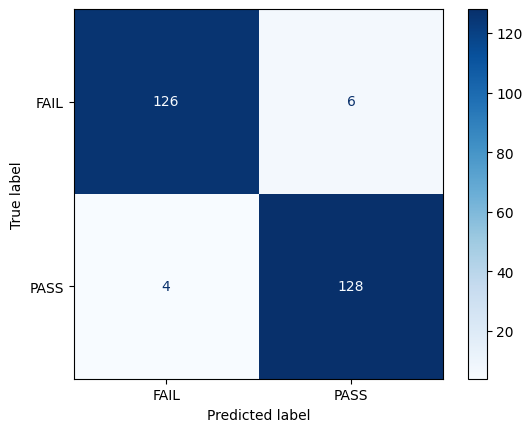

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAIL', 'PASS'])
disp.plot(cmap='Blues')


In [21]:
import numpy as np

# Create a copy of test_ds
test_ds_shuffled = test_ds.select(range(len(test_ds)))

# Shuffle the labels
labels = np.array(test_ds_shuffled['labels'])
np.random.seed(42)
np.random.shuffle(labels)

# Replace the labels with the shuffled labels
test_ds_shuffled = test_ds_shuffled.remove_columns('labels').add_column('labels', labels)

# Evaluate on the shuffled labels
results_shuffled = trainer.evaluate(test_ds_shuffled)
print("Test set results (shuffled labels):", results_shuffled)



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Test set results (shuffled labels): {'eval_loss': 3.0011045932769775, 'eval_accuracy': 0.5, 'eval_precision': 0.5, 'eval_recall': 0.5075757575757576, 'eval_f1': 0.5037593984962406, 'eval_runtime': 8.1664, 'eval_samples_per_second': 32.328, 'eval_steps_per_second': 4.041, 'epoch': 3.0}


In [17]:
import pandas as pd
import numpy as np

label_map = {0: "FAIL", 1: "PASS"}

# Build final DataFrame with predictions + original inputs
df_final = pd.DataFrame(test_ds)
df_final["true_label"] = [label_map[i] for i in preds.label_ids]
df_final["predicted_label"] = [label_map[i] for i in np.argmax(preds.predictions, axis=1)]
df_final["confidence"] = np.max(preds.predictions, axis=1)

# Save and preview
df_final.to_csv("deberta_crossencoder_test_predictions.csv", index=False)
df_final.sample(5)


,query,context,response,labels,query_context,input_ids,token_type_ids,attention_mask,true_label,predicted_label,confidence
68,What distinction was awarded to the Indian Car...,Madhvacharya (1986) is a Kannada language film...,Best Music Director,1,Query: What distinction was awarded to the Ind...,"[1, 34359, 294, 458, 8537, 284, 3864, 264, 262...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",PASS,PASS,2.445155
194,What do you charge for an exchange fee?,### Exchange Fees\r\n\r\nWhen you conduct inte...,"For standard international money transfers, ou...",1,Query: What do you charge for an exchange fee?...,"[1, 34359, 294, 458, 333, 274, 1541, 270, 299,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",PASS,PASS,2.620345
82,The suburb east of Christie Downs has what lan...,"It has a unique postcode of 5164, and is adja...",12.76 km²,1,Query: The suburb east of Christie Downs has w...,"[1, 34359, 294, 279, 16003, 3611, 265, 15251, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",PASS,PASS,2.578770
247,How long will I have to wait for my money to b...,### Transfer Timing: How Long Will It Take for...,The timing for your funds to be available in y...,0,Query: How long will I have to wait for my mon...,"[1, 34359, 294, 577, 455, 296, 273, 286, 264, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",FAIL,PASS,0.046451
109,Chris Stewart plays for a professional ice hoc...,"Chris Stewart (born October 30, 1987) is a Can...",The Minnesota Wild plays in St. Paul in the Mi...,0,Query: Chris Stewart plays for a professional ...,"[1, 34359, 294, 2753, 7978, 2787, 270, 266, 90...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",FAIL,FAIL,3.497576


## 7  Save fine‑tuned model

In [14]:
trainer.save_model('deberta_crossencoder_halueval')
tokenizer.save_pretrained('deberta_crossencoder_halueval')

('deberta_crossencoder_halueval/tokenizer_config.json',
 'deberta_crossencoder_halueval/special_tokens_map.json',
 'deberta_crossencoder_halueval/spm.model',
 'deberta_crossencoder_halueval/added_tokens.json',
 'deberta_crossencoder_halueval/tokenizer.json')